
# Structure-preserving shallow waters discretization

This notebook implements a structure preserving discretization for the shallow waters equations
using two different time integrators:
  - A midpoint rule time integrator
  - A Poisson time integrator



## Load required libraries
  - Firedrake is the main FEM library
  - numpy is used to store diagnostics results and to save them to a file
  - matplotlib is used for plotting the diagnostics in time
  - os and time are use only to generate the output file in the correct place and with the nice names


In [1]:
import firedrake
import numpy
import os
import time

from matplotlib import pyplot

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance



## Environment setup
Generate folder where to save each run (they are saved inside results folder and named by time of run)


In [2]:
results_path = './results/' + time.strftime('%Y_%m_%d_%H_%M_%S', time.localtime()) + "/"
if not os.path.exists(results_path):
    os.makedirs(results_path)

## Parameters 

### Spatial discretization


In [3]:
Lx = 1.0  # domain size in the x-direction
Ly = 1.0  # domain size in the y-direction
n_elements = 10  # number of subdivisions in x- and y-directions
p = 1  # polynomial degree of de Rham complex

### Temporal discretization
You can seet the time integrator to use, the time step, and the number of time steps.

In [4]:
time_integrator = "poisson"  # you can choose either "midpoint" or "poisson" 
dt = 0.01  # time step size
n_t_steps = 200  # number of time steps to compute

### Nonlinear solver parameters


In [5]:
newton_tol = 1e-10  # tolerance to reach to finish Newton-Raphson nonlinear solve step
newton_max_iter = 20  # maximum number of iterations to perform per Newton-Raphson solve step

### Linear solver parameters
Simply use a direct solver


In [6]:
MUMPS = {
        "snes_monitor": None,
        "snes_max_it":1000,
        "ksp_type": "preonly",
        "mat_type": "aij",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps"
        }

### Internal auxiliary definitions


In [7]:
g = 10.0  # gravitational acceleration

## Initial conditions


### Initial conditions for fluid elevation: h(t = 0)


In [8]:
def h_0_lambda(x, y):
    sigma = 0.05
    amplitude = 0.01
    return firedrake.Constant(1.0) + amplitude*firedrake.exp(-0.5*((x - 0.5*Lx)**2)/sigma**2)*(1.0/(sigma*firedrake.sqrt(2.0*numpy.pi))) * firedrake.exp(-0.5*((y - 0.5*Ly)**2)/sigma**2)*(1.0/(sigma*firedrake.sqrt(2.0*numpy.pi)))

### Initial conditions for fluid velocity: u(t = 0)


In [9]:
def u_0_lambda(x, y):
    return firedrake.as_vector([firedrake.Constant(0.0), firedrake.Constant(0.0)])



sol_outfile = firedrake.VTKFile(results_path + "shallow_waters.pvd")  # file name where to solve solution for plotting

## Auxiliary functions extending Firedrake's functionality
Implements specific functions required for 2D computations and not directly available in Firedrake:

The rotational (curl of a scalar $w$, i.e., a vector $w \vec{e}_{z}$)
 $$
 \mathrm{rot}(w) := \frac{\partial w}{\partial y}\vec{e}_{x} - \frac{\partial w}{\partial x}\vec{e}_{y}
 $$

The cross product ($\times$) between two vectors $\vec{u}$ and $\vec{v}$ in 2D

$$
\vec{u} \times \vec{v} := u_{x}v_{y} - u_{y}v_{x}
$$

The cross product between a scalar $w$, i.e., a vector $w \vec{e}_{z}$, and a vector $\vec{v}$ in 2D

$$
w \times \vec{v} := -w v_{y}\vec{e}_{x} + w v_{x}\vec{e}_{y}
$$

In [10]:

# Triple product (not used in the end)
def triple_product(w, u, v):
    return w*u[0]*v[1]-w*u[1]*v[0]

# Rot
def rot(w):
    return firedrake.as_vector([w.dx(1),-w.dx(0)])

# Cross product in 2D
def cross_2d(u, v):
    return u[0]*v[1]-u[1]*v[0]

# Corss product between a scalar (vector in z-direction) and a vector in 2D
def cross_scalar(w, v):
    return firedrake.as_vector([-w*v[1], w*v[0]])

## Construct the mesh
Constructs a periodic quadrilateral mesh with `n_elements` $\times$ `n_elements` over a rectangular 
domain of dimensions `Lx` $\times$ `Ly`.

You can make a triangular mesh by setting `quadrilateral=False`. If you do this, you need to change the 
function space `D` below (see instructions there).

In [11]:
mesh = firedrake.PeriodicRectangleMesh(n_elements, n_elements, Lx, Ly, quadrilateral=True) 
x, y = firedrake.SpatialCoordinate(mesh)  # these are the coordinate variables of the mesh, necessary to use in expressions
n_vector = firedrake.FacetNormal(mesh)  # the normal vectors at the mesh cell interfaces (not used in this case)

## Define the function spaces and the solution fields
Firedrake (and most FEM solvers) work in a similar to how the problem is setup analytically. You need to:
  1. Define the function spaces
  2. Define your unknown fields as element of these spaces
  3. Setup mixed spaces (collection of several spaces) to solve a problem with several unknown fields   

The first two steps we perform here, the other one we perform inside the function that implement each time integrator.
This was chosen because some time integrators may require different solves and therefore different mixed spaces.
This is just a technical detail of the specific implementation in Firedrake.


### Define the function spaces for the de Rham complex of degree p
As discussed in the lectures we will need a set of spaces from a discrete de Rham complex.
This is what is done here using some of the spaces available in Firedrake. Note that this 
specific choice of spaces we make here leads to the correct polynomials degrees, i.e.,

$$
\mathbb{R} \xhookrightarrow{} G \stackrel{\nabla\times}{\longrightarrow} D \stackrel{\nabla\cdot}{\longrightarrow} S \longrightarrow 0
$$

and the polynomial degrees for each component in x- and y-directions are

$$
(p, p) \stackrel{\nabla\times}{\longrightarrow} (p, p-1) \times (p-1, p) \stackrel{\nabla\cdot}{\longrightarrow} (p-1, p-1)
$$

__NOTE__: If you chose triangular mesh above, by setting `quadrilateral=True`, then you need to change the `D` space
to be spanned by the Raviart-Thomas elements by using the line
```python
D = firedrake.FunctionSpace(mesh, "RT", p)
```

In [12]:
G = firedrake.FunctionSpace(mesh, "CG", p)  # standard continuous Galerkin elements (nodal interpolants) of degree (p,p), G \subset H^{1}
D = firedrake.FunctionSpace(mesh, "RTCF", p)  # mimetic flux edge basis functions (in 2D) of degree (p, p-1) x (p-1, p), D \subset H(div)
S = firedrake.FunctionSpace(mesh, "DQ L2", p - 1)  # standard discontinuous Galerkin elements of degree (p-1, p-1), S \subset L^{2}

### Setup solution fields 
Throughout this code we use the following notation
  - the subscript 0 refers to the current time step solution (known field value)
  - the subscript 1 refers to the next time step solution (unknown field value)
  - for the prognostic variables ($\vec{u}$ and $h$) the subscripts correspond to the
    integer time steps: $t$ and $t + \Delta t$.
  - for the diagnostic variables ($vec{F}#, $q$, $K$) the subscripts correspond to the
    fractional time steps: $t - \frac{1}{2}\Delta t$ and $t + \frac{1}{2}\Delta t$.


In [13]:
# Velocity field
u_0 = firedrake.Function(D)  # current time step
u_1 = firedrake.Function(D)  # next time step

# Fluid depth field
h_0 = firedrake.Function(S)  # current time step
h_1 = firedrake.Function(S)  # next time step

# Potential vorticity field
q_0 = firedrake.Function(G)  # current time step
q_1 = firedrake.Function(G)  # next time step

# Mass flux
F_0 = firedrake.Function(D)  # current time step
F_1 = firedrake.Function(D)  # next time step

# Kinetic energy
K_0 = firedrake.Function(S)  # current time step
K_1 = firedrake.Function(S)  # next time step

# Assign names to the fields for saving to VTK file with nice names
u_1.rename("Velocity", "Velocity")
q_1.rename("Potential vorticity","Potential vorticity")
h_1.rename("Fluid depth","Fluid depth")
F_1.rename("Mass flux","Mass flux")
K_1.rename("Kinetic energy","Kinetic energy")

## Define the time integrators


### Define the midpoint integrator one-step evolution function


In [14]:
def advance_mid_point_newton(u_0, u_1, h_0, h_1, q_0, q_1, K_0, K_1, F_0, F_1, G, D, S, dt):
    # Note that here the unknowns are:
    #   u^{k+1}, h^{k+1}, q^{k+1} --> All at the next time step as for the midpoint rule
    #   F^{k+1/2}, K^{k + 1/2}  --> These two are computed at the midpoint
    #                               F^{k+1/2} = F_1 and K^{k+1/2} = K_1
    #                               F^{k-1/2} = F_0 and K^{k-1/2} = K_0

    # Setup the mixed space and the trial and test functions
    M = D * S * G * S * D  # (u, h, q, K, F)
    mixed_u_trial, mixed_h_trial, mixed_q_trial, mixed_K_trial, mixed_F_trial = firedrake.TrialFunctions(M)
    mixed_u_test, mixed_h_test, mixed_q_test, mixed_K_test, mixed_F_test = firedrake.TestFunctions(M)

    # Define the update solution for the Newton-Rapshon iterative solve
    dsol = firedrake.Function(M)  # Newton correction
    du, dh, dq, dK, dF = dsol.subfunctions

    # Define temporary solution for updating the solution during Newton-Raphson method (this is very much Firedrake dependent)
    sol_temp = firedrake.Function(M)  # temporary next time step for fixed-point error computation
    u_temp, h_temp, q_temp, K_temp, F_temp = sol_temp.subfunctions

    # Initialyze Newton-Raphson iteration
    newton_iter = 1
    newton_error = 1.0

    # Print columns labels of Newton-Raphson output information
    print("                           u         |           h         |           q         |           K         |            F")
        
    while (newton_error > newton_tol) and (newton_iter < newton_max_iter):
        # Setup Newton method

        # Right hand side
        F = firedrake.inner(u_1 - u_0, mixed_u_test)*firedrake.dx + \
            dt*firedrake.inner(cross_scalar(q_1, F_1), mixed_u_test)*firedrake.dx - \
            dt*firedrake.inner(K_1, firedrake.div(mixed_u_test))*firedrake.dx - \
            0.5*g*dt*firedrake.inner(h_0 + h_1, firedrake.div(mixed_u_test))*firedrake.dx + \
            firedrake.inner(h_1 - h_0, mixed_h_test)*firedrake.dx + \
            0.5*dt*firedrake.inner(firedrake.div(F_1), mixed_h_test)*firedrake.dx + \
            firedrake.inner(0.5*(h_1+ h_0)*q_1, mixed_q_test)*firedrake.dx - \
            firedrake.inner(0.5*(u_1 + u_0), rot(mixed_q_test))*firedrake.dx + \
            firedrake.inner(K_1, mixed_K_test)*firedrake.dx - \
            0.5*firedrake.inner(0.5*(u_1 + u_0), 0.5*(u_1 + u_0)*mixed_K_test)*firedrake.dx + \
            firedrake.inner(F_1, mixed_F_test)*firedrake.dx - \
            firedrake.inner(0.5*(h_1*u_1 + h_0*u_0), mixed_F_test)*firedrake.dx
        
        # Jacobian
        a = firedrake.inner(mixed_u_trial, mixed_u_test)*firedrake.dx + \
            0.5*dt*firedrake.inner(cross_scalar(mixed_q_trial, F_1), mixed_u_test)*firedrake.dx + \
            0.5*dt*firedrake.inner(cross_scalar(q_0 + q_1, mixed_F_trial), mixed_u_test)*firedrake.dx - \
            0.5*dt*firedrake.inner(mixed_K_trial, firedrake.div(mixed_u_test))*firedrake.dx - \
            0.5*g*dt*firedrake.inner(mixed_h_trial, firedrake.div(mixed_u_test))*firedrake.dx + \
            firedrake.inner(mixed_h_trial, mixed_h_test)*firedrake.dx + \
            0.5*dt*firedrake.inner(firedrake.div(mixed_F_trial), mixed_h_test)*firedrake.dx + \
            0.5*firedrake.inner(mixed_h_trial*q_1, mixed_q_test)*firedrake.dx + \
            0.5*firedrake.inner((h_1 + h_0)*mixed_q_trial, mixed_q_test)*firedrake.dx - \
            0.5*firedrake.inner(mixed_u_trial, rot(mixed_q_test))*firedrake.dx + \
            firedrake.inner(mixed_K_trial, mixed_K_test)*firedrake.dx - \
            firedrake.inner(0.5*mixed_u_trial, 0.5*(u_1 + u_0)*mixed_K_test)*firedrake.dx + \
            firedrake.inner(mixed_F_trial, mixed_F_test)*firedrake.dx - \
            0.5*firedrake.inner(mixed_h_trial*u_1, mixed_F_test)*firedrake.dx - \
            0.5*firedrake.inner(h_1*mixed_u_trial, mixed_F_test)*firedrake.dx

        # Solve fixed point update step
        A = firedrake.assemble(a)
        b = firedrake.assemble(F)

        firedrake.solve(A, dsol.vector(), b, solver_parameters=MUMPS)

        # Compute Newton error 
        newton_error_u = firedrake.norm(du)
        newton_error_h = firedrake.norm(dh)
        newton_error_q = firedrake.norm(dq)
        newton_error_K = firedrake.norm(dK)
        newton_error_F = firedrake.norm(dF)
        newton_error = newton_error_u + newton_error_h + newton_error_q + newton_error_K + newton_error_F

        print("   Newton error: {newton_error_u:19.16f} | {newton_error_h:19.16f} | {newton_error_q:19.16f} | "\
                "{newton_error_K:19.16f} | {newton_error_F:19.16f}".format(newton_error_u=newton_error_u, \
                newton_error_h=newton_error_h, newton_error_q=newton_error_q, newton_error_K=newton_error_K, \
                newton_error_F=newton_error_F))
        
        # Update solution
        u_temp.vector()[:] = u_1.vector()[:] - du.vector()[:]
        h_temp.vector()[:] = h_1.vector()[:] - dh.vector()[:]
        q_temp.vector()[:] = q_1.vector()[:] - dq.vector()[:]
        K_temp.vector()[:] = K_1.vector()[:] - dK.vector()[:]
        F_temp.vector()[:] = F_1.vector()[:] - dF.vector()[:]

        u_1.assign(u_temp)
        h_1.assign(h_temp)
        q_1.assign(q_temp)
        K_1.assign(K_temp)
        F_1.assign(F_temp)

### Define the Poisson integrator one-step evolution function


In [15]:
def advance_poisson_newton(u_0, u_1, h_0, h_1, q_0, q_1, K_0, K_1, F_0, F_1, G, D, S, dt):
    # Note that here the unknowns are:
    #   u^{k+1}, h^{k+1}, q^{k+1} --> All at the next time step as for the midpoint rule
    #   F^{k+1/2}, K^{k + 1/2}  --> These two are computed at the midpoint with a symmetrizing average
    #                               F^{k+1/2} = F_1 and K^{k+1/2} = K_1
    #                               F^{k-1/2} = F_0 and K^{k-1/2} = K_0

    M = D * S * G * S * D  # (u, h, q, K, F)
    mixed_u_trial, mixed_h_trial, mixed_q_trial, mixed_K_trial, mixed_F_trial = firedrake.TrialFunctions(M)
    mixed_u_test, mixed_h_test, mixed_q_test, mixed_K_test, mixed_F_test = firedrake.TestFunctions(M)

    dsol = firedrake.Function(M)  # Newton correction
    du, dh, dq, dK, dF = dsol.subfunctions

    sol_temp = firedrake.Function(M)  # temporary next time step for fixed-point error computation
    u_temp, h_temp, q_temp, K_temp, F_temp = sol_temp.subfunctions

    newton_iter = 1
    newton_error = 1.0

    # Print columns labels of Newton-Raphson output information
    print("                           u         |           h         |           q         |           K         |            F")
        
    while (newton_error > newton_tol) and (newton_iter < newton_max_iter):

        # Setup Newton method
        
        # Right hand side
        F = firedrake.inner(u_1 - u_0, mixed_u_test)*firedrake.dx + \
            0.5*dt*firedrake.inner(cross_scalar(q_0 + q_1, F_1), mixed_u_test)*firedrake.dx - \
            dt*firedrake.inner(K_1, firedrake.div(mixed_u_test))*firedrake.dx - \
            0.5*g*dt*firedrake.inner(h_0 + h_1, firedrake.div(mixed_u_test))*firedrake.dx + \
            firedrake.inner(h_1 - h_0, mixed_h_test)*firedrake.dx + \
            dt*firedrake.inner(firedrake.div(F_1), mixed_h_test)*firedrake.dx + \
            firedrake.inner(h_1*q_1, mixed_q_test)*firedrake.dx - \
            firedrake.inner(u_1, rot(mixed_q_test))*firedrake.dx + \
            firedrake.inner(K_1, mixed_K_test)*firedrake.dx - \
            (1.0/6.0)*firedrake.inner(u_1, u_1*mixed_K_test)*firedrake.dx - \
            (1.0/6.0)*firedrake.inner(u_1, u_0*mixed_K_test)*firedrake.dx - \
            (1.0/6.0)*firedrake.inner(u_0, u_0*mixed_K_test)*firedrake.dx + \
            firedrake.inner(F_1, mixed_F_test)*firedrake.dx - \
            (1.0/3.0)*firedrake.inner(h_0*u_0, mixed_F_test)*firedrake.dx - \
            (1.0/6.0)*firedrake.inner(h_0*u_1, mixed_F_test)*firedrake.dx - \
            (1.0/6.0)*firedrake.inner(h_1*u_0, mixed_F_test)*firedrake.dx - \
            (1.0/3.0)*firedrake.inner(h_1*u_1, mixed_F_test)*firedrake.dx
        
        # Jacobian
        a = firedrake.inner(mixed_u_trial, mixed_u_test)*firedrake.dx + \
            0.5*dt*firedrake.inner(cross_scalar(mixed_q_trial, F_1), mixed_u_test)*firedrake.dx + \
            0.5*dt*firedrake.inner(cross_scalar(q_0 + q_1, mixed_F_trial), mixed_u_test)*firedrake.dx - \
            dt*firedrake.inner(mixed_K_trial, firedrake.div(mixed_u_test))*firedrake.dx - \
            0.5*g*dt*firedrake.inner(mixed_h_trial, firedrake.div(mixed_u_test))*firedrake.dx + \
            firedrake.inner(mixed_h_trial, mixed_h_test)*firedrake.dx + \
            dt*firedrake.inner(firedrake.div(mixed_F_trial), mixed_h_test)*firedrake.dx + \
            firedrake.inner(mixed_h_trial*q_1, mixed_q_test)*firedrake.dx + \
            firedrake.inner(h_1*mixed_q_trial, mixed_q_test)*firedrake.dx - \
            firedrake.inner(mixed_u_trial, rot(mixed_q_test))*firedrake.dx + \
            firedrake.inner(mixed_F_trial, mixed_F_test)*firedrake.dx - \
            (1.0/6.0)*firedrake.inner(h_1*mixed_u_trial, mixed_F_test)*firedrake.dx - \
            (1.0/6.0)*firedrake.inner(mixed_h_trial*u_1, mixed_F_test)*firedrake.dx - \
            (1.0/3.0)*firedrake.inner(h_1*mixed_u_trial, mixed_F_test)*firedrake.dx - \
            (1.0/3.0)*firedrake.inner(mixed_h_trial*u_1, mixed_F_test)*firedrake.dx + \
            firedrake.inner(mixed_K_trial, mixed_K_test)*firedrake.dx - \
            (1.0/6.0)*firedrake.inner(mixed_u_trial, u_0*mixed_K_test)*firedrake.dx - \
            (1.0/3.0)*firedrake.inner(mixed_u_trial, u_1*mixed_K_test)*firedrake.dx
        
        # Solve fixed point update step
        A = firedrake.assemble(a)
        b = firedrake.assemble(F)

        firedrake.solve(A, dsol.vector(), b, solver_parameters=MUMPS)

        # Compute Newton error 
        newton_error_u = firedrake.norm(du)
        newton_error_h = firedrake.norm(dh)
        newton_error_q = firedrake.norm(dq)
        newton_error_K = firedrake.norm(dK)
        newton_error_F = firedrake.norm(dF)
        newton_error = newton_error_u + newton_error_h + newton_error_q + newton_error_K + newton_error_F

        print("   Newton error: {newton_error_u:19.16f} | {newton_error_h:19.16f} | {newton_error_q:19.16f} | "\
                "{newton_error_K:19.16f} | {newton_error_F:19.16f}".format(newton_error_u=newton_error_u, \
                newton_error_h=newton_error_h, newton_error_q=newton_error_q, newton_error_K=newton_error_K, \
                newton_error_F=newton_error_F))
        
        # Update solution
        u_temp.vector()[:] = u_1.vector()[:] - du.vector()[:]
        h_temp.vector()[:] = h_1.vector()[:] - dh.vector()[:]
        q_temp.vector()[:] = q_1.vector()[:] - dq.vector()[:]
        K_temp.vector()[:] = K_1.vector()[:] - dK.vector()[:]
        F_temp.vector()[:] = F_1.vector()[:] - dF.vector()[:]

        u_1.assign(u_temp)
        h_1.assign(h_temp)
        q_1.assign(q_temp)
        K_1.assign(K_temp)
        F_1.assign(F_temp)

## Start time evolution


### Setup the initial conditions

In [16]:
u_0 = firedrake.Function(D).project(u_0_lambda(x, y))
h_0 = firedrake.Function(S).project(h_0_lambda(x, y))

u_1.assign(u_0)
h_1.assign(h_0)

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x126653c10>, FiniteElement('DQ L2', quadrilateral, 0), name=None), Mesh(VectorElement(FiniteElement('DQ', quadrilateral, 1, variant='equispaced'), dim=2, variant='equispaced'), 6)), 12)

### Allocate memory for simulation diagnostics
During time evolution we will compute the kinetic energy $K$, potential energy $P$, total energy $E$,
enstrophy $E$, and total volume $V$.


In [17]:
energy_K = numpy.zeros(n_t_steps)
energy_P = numpy.zeros(n_t_steps)
energy = numpy.zeros(n_t_steps)
enstrophy = numpy.zeros(n_t_steps)
volume = numpy.zeros(n_t_steps)

### Export the initial condition to paraview 
The solution at each time step will be exported to paraview for visualization, we start with the initial condition 
Note that the diagnostic variables $q$, $K$, and $\vec{F}$ are zero at the first time step, simply because 
we do not compute them at the start point, as you recall we compute them at fractional time steps, therefore 
there is asynchrocity, we chose leave the first value of these variables at zero.


In [18]:
sol_outfile.write(u_1, h_1, q_1, K_1, F_1, time = 0.0)

## Advance solution in time
Here we advance the solution in time using either of
  - the midpoint rule time integrator 
  - Poisson time integrator

You can select which to use by setting the variable 
  - `time_integrator = "midpoint"`
  - `time_integrator = "poisson"`

see above.

In [19]:
for time_step in range(0, n_t_steps):
    print("\nT step: " + str(time_step))

    # Reinitialize initial conditions
    u_0.assign(u_1)
    h_0.assign(h_1)
    q_0.assign(q_1)
    K_0.assign(K_1)
    F_0.assign(F_1)

    # Step in time
    if time_integrator == "midpoint":
        advance_mid_point_newton(u_0, u_1, h_0, h_1, q_0, q_1, K_0, K_1, F_0, F_1, G, D, S, dt)
    elif time_integrator == "poisson":
        advance_poisson_newton(u_0, u_1, h_0, h_1, q_0, q_1, K_0, K_1, F_0, F_1, G, D, S, dt)
    else:
        raise Exception("Type of time integrator not recognized, you can use: midpoint or poisson")
    
    # Export the solutions to paraview 
    sol_outfile.write(u_1, h_1, q_1, K_1, F_1, time = dt*time_step)

    # Compute simulation diagnostics
    # Energy
    if time_integrator == "midpoint":
        energy_K[time_step] = 0.25*firedrake.assemble(firedrake.inner(u_1 + u_0, F_1)*firedrake.dx)
        energy_P[time_step] = 0.25*firedrake.assemble(firedrake.inner(h_1+h_0, 0.5*g*(h_1+h_0))*firedrake.dx)
        energy[time_step] = energy_K[time_step] + energy_P[time_step]
    elif time_integrator == "poisson":
        energy_K[time_step] = 0.5*firedrake.assemble(firedrake.inner(u_1, u_1*h_1)*firedrake.dx)
        energy_P[time_step] = 0.5*firedrake.assemble(firedrake.inner(h_1, 0.5*g*h_1)*firedrake.dx)
        energy[time_step] = energy_K[time_step] + energy_P[time_step]
    else:
        raise Exception("Type of time integrator not recognized, you can use: midpoint or poisson")
    
    # Potential enstrophy
    enstrophy[time_step] = 0.5*firedrake.assemble(firedrake.inner(h_1*q_1, q_1)*firedrake.dx)
    
    # Volume
    volume[time_step] = firedrake.assemble(h_1*firedrake.dx)

    # Print diagnostics
    print("\n                          K+P        |           K         |           P         |           E         |            V")
    print("   Diagnostics : {energy:19.16f} | {energy_K:19.16f} | {energy_P:19.16f} | "\
                "{enstrophy:19.16f} | {volume:19.16f}".format(energy=energy[time_step], \
                energy_K=energy_K[time_step], energy_P=energy_P[time_step], enstrophy=enstrophy[time_step], \
                volume=volume[time_step]))
    print("   [t] - [t-dt]: {denergy:19.16f} | {denergy_K:19.16f} | {denergy_P:19.16f} | "\
                "{denstrophy:19.16f} | {dvolume:19.16f}".format(denergy=energy[time_step]-energy[time_step-1], \
                denergy_K=energy_K[time_step]-energy_K[time_step-1], denergy_P=energy_P[time_step]-energy_P[time_step-1], \
                denstrophy=enstrophy[time_step]-enstrophy[time_step-1], dvolume=volume[time_step]-volume[time_step-1]))
    print("   [t] - [0]   : {denergy:19.16f} | {denergy_K:19.16f} | {denergy_P:19.16f} | "\
                "{denstrophy:19.16f} | {dvolume:19.16f}".format(denergy=energy[time_step]-energy[0], \
                denergy_K=energy_K[time_step]-energy_K[0], denergy_P=energy_P[time_step]-energy_P[0], \
                denstrophy=enstrophy[time_step]-enstrophy[0], dvolume=volume[time_step]-volume[0]))
    
    # Save diagnostics to file each time step (to be safe)
    diagnostics_filename = results_path + "diagnostics.npz"
    numpy.savez(diagnostics_filename, energy=energy, energy_K=energy_K, energy_P=energy_P, enstrophy=enstrophy, volume=volume)
    
    # Update the time step
    time_step += 1


T step: 0
                           u         |           h         |           q         |           K         |            F
   Newton error:  0.0671836018201799 |  0.0085113390204765 |  0.0000000000000034 |  0.0000000000000000 |  0.0377723028290415
   Newton error:  0.0002641363941104 |  0.0000546619503705 |  0.0000000000000059 |  0.0023378096948622 |  0.0001854712100644
   Newton error:  0.0000001488253036 |  0.0000001047774606 |  0.0000000000000066 |  0.0000000233850671 |  0.0000004834875910
   Newton error:  0.0000000004032796 |  0.0000000002555557 |  0.0000000000000087 |  0.0000000000193386 |  0.0000000008844551
   Newton error:  0.0000000000006074 |  0.0000000000003762 |  0.0000000000000091 |  0.0000000000000185 |  0.0000000000016698

                          K+P        |           K         |           P         |           E         |            V
   Diagnostics :  2.5564783019410542 |  0.0025339245297478 |  2.5539443774113062 |  0.0000000000000000 |  1.0100000001716030
  

### Save results to file 


In [20]:
diagnostics_filename = results_path + "diagnostics.npz"
numpy.savez(diagnostics_filename, energy=energy, energy_K=energy_K, energy_P=energy_P, enstrophy=enstrophy, volume=volume)

### Plot the diagnostics results


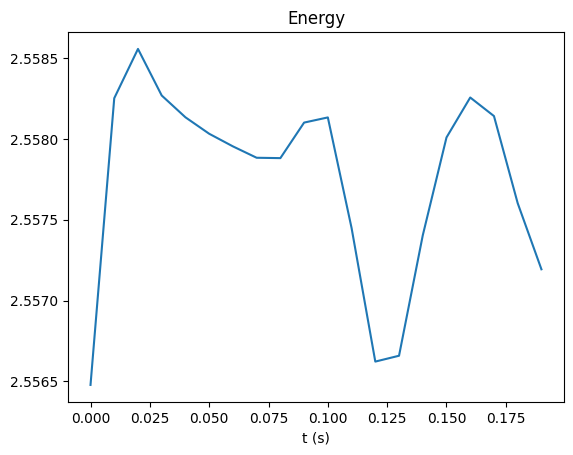

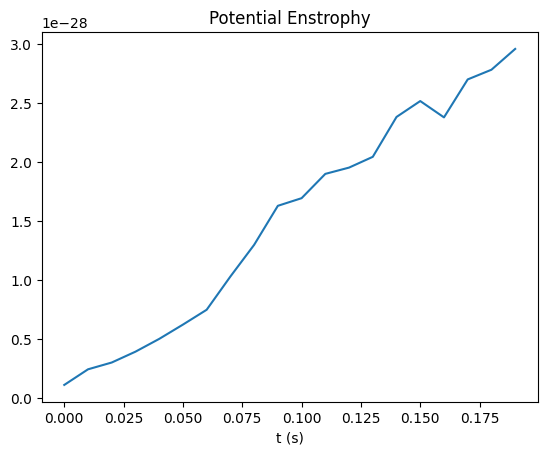

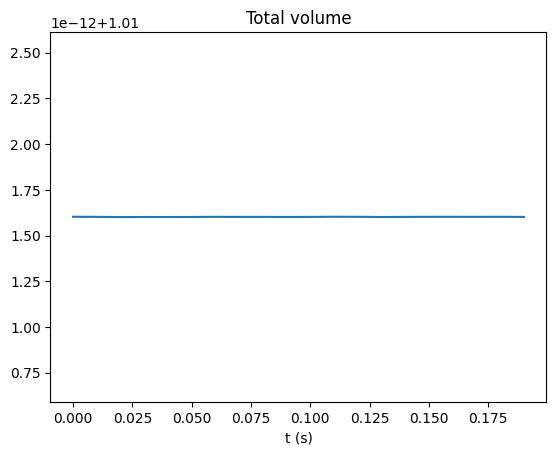

In [21]:
#  Energy
pyplot.figure()
pyplot.plot(numpy.arange(0, n_t_steps)*dt, energy)
pyplot.title("Energy")
pyplot.xlabel("t (s)")
energy_plot_filename = results_path + "energy.pdf"
pyplot.savefig(energy_plot_filename, format='pdf', dpi=200)

#  Potential enstrophy
pyplot.figure()
pyplot.plot(numpy.arange(0, n_t_steps)*dt, enstrophy)
pyplot.title("Potential Enstrophy")
pyplot.xlabel("t (s)")
energy_plot_filename = results_path + "enstrophy.pdf"
pyplot.savefig(energy_plot_filename, format='pdf', dpi=200)

#  Volume
pyplot.figure()
pyplot.plot(numpy.arange(0, n_t_steps)*dt, volume)
pyplot.title("Total volume")
pyplot.xlabel("t (s)")
energy_plot_filename = results_path + "volume.pdf"
pyplot.savefig(energy_plot_filename, format='pdf', dpi=200)

pyplot.show()